In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
LOCAL_BASE_DIR = "/Users/georgiikuznetsov/Desktop/coding/CNN_nutrition/nutrition5k"
LOCAL_BASE_DIR = "/users/eleves-b/2023/georgii.kuznetsov/CNN_nutrition/nutrition5k"

IMAGERY_DIR_LOCAL_FULL = os.path.join(LOCAL_BASE_DIR, "imagery/realsense_overhead")
METADATA_FILE_CAFE1 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe1.csv")
METADATA_FILE_CAFE2 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe2.csv")

assert(os.path.exists(LOCAL_BASE_DIR))
assert(os.path.exists(IMAGERY_DIR_LOCAL_FULL))
assert(os.path.exists(METADATA_FILE_CAFE1))
assert(os.path.exists(METADATA_FILE_CAFE2))

RGB_IMAGE_FILENAME = "rgb.png" 

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10

In [ ]:
TARGET_COLUMNS = ['calories', 'weight', 'fat', 'carbs', 'protein']

In [ ]:
# Store data

%store TARGET_COLUMNS
%store DEVICE
%store BATCH_SIZE
%store LEARNING_RATE
%store NUM_EPOCHS

## LOADING DATA

In [ ]:
def parse_nutrition_csv(file_path):
    dishes = []
    ingredients_list = []
    
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if not parts[0].startswith('dish_'):
                continue
                
            # Extract dish info (first 6 fields)
            dish_id = parts[0]
            dish_calories = float(parts[1])
            dish_weight = float(parts[2])
            dish_fat = float(parts[3])
            dish_carbs = float(parts[4])
            dish_protein = float(parts[5])
            
            dishes.append({
                'dish_id': dish_id,
                'calories': dish_calories,
                'weight': dish_weight,
                'fat': dish_fat,
                'carbs': dish_carbs,
                'protein': dish_protein
            })
            
            # Extract ingredients (in groups of 7 fields)
            ingredient_data = parts[6:]
            i = 0
            while i < len(ingredient_data) - 6:
                if not ingredient_data[i].startswith('ingr_'):
                    break
                    
                ingredients_list.append({
                    'dish_id': dish_id,
                    'ingredient_id': ingredient_data[i],
                    'ingredient_name': ingredient_data[i+1],
                    'amount': float(ingredient_data[i+2]),
                    'calories': float(ingredient_data[i+3]),
                    'fat': float(ingredient_data[i+4]),
                    'carbs': float(ingredient_data[i+5]),
                    'protein': float(ingredient_data[i+6])
                })
                i += 7
    
    # Create two separate dataframes
    dish_df = pd.DataFrame(dishes)
    ingredient_df = pd.DataFrame(ingredients_list)
    
    return dish_df, ingredient_df

In [ ]:
dish_df_cafe1, ingredient_df_cafe1 = parse_nutrition_csv(METADATA_FILE_CAFE1)
dish_df_cafe2, ingredient_df_cafe2 = parse_nutrition_csv(METADATA_FILE_CAFE2)

if not dish_df_cafe1.empty and not dish_df_cafe2.empty:
    dish_metadata_df = pd.concat([dish_df_cafe1, dish_df_cafe2], ignore_index=True)
    ingredient_metadata_df = pd.concat([ingredient_df_cafe1, ingredient_df_cafe2], ignore_index=True)
elif not dish_df_cafe1.empty:
    dish_metadata_df = dish_df_cafe1
    ingredient_metadata_df = ingredient_df_cafe1
elif not dish_df_cafe2.empty:
    dish_metadata_df = dish_df_cafe2
    ingredient_metadata_df = ingredient_df_cafe2
else:
    raise Exception("No metadata files found or loaded. Please check paths.")

print("\n---DISHES---")
print(f"Combined dish metadata shape: {dish_metadata_df.shape}\n", dish_metadata_df.head())
print(dish_metadata_df.describe())
print("\n\n---INGREDIENTS---")
print(f"Combined ingredient metadata shape: {ingredient_metadata_df.shape}\n", ingredient_metadata_df.head())
print(ingredient_metadata_df.describe())

In [ ]:
available_dish_ids_in_imagery = []
if os.path.exists(IMAGERY_DIR_LOCAL_FULL):
    for dish_id_folder in os.listdir(IMAGERY_DIR_LOCAL_FULL):
        rgb_path = os.path.join(IMAGERY_DIR_LOCAL_FULL, dish_id_folder, RGB_IMAGE_FILENAME)
        # Add a check for mask if MASKS_DIR is specified and used
        # mask_path_exists = True # Assume true if not using masks
        # if MASKS_DIR:
        #    mask_path = os.path.join(MASKS_DIR, dish_id_folder, dish_id_folder + MASK_IMAGE_FILENAME_SUFFIX)
        #    mask_path_exists = os.path.exists(mask_path)

        if os.path.isdir(os.path.join(IMAGERY_DIR_LOCAL_FULL, dish_id_folder)) and \
           os.path.exists(rgb_path): # and mask_path_exists:
            available_dish_ids_in_imagery.append(dish_id_folder)
else:
    print(f"Warning: Imagery directory {IMAGERY_DIR_LOCAL_FULL} not found.")

print(f"Found {len(available_dish_ids_in_imagery)} dish IDs with RGB images in the local imagery folder.")

In [ ]:
if not dish_metadata_df.empty:
    filtered_metadata_df = dish_metadata_df[dish_metadata_df['dish_id'].isin(available_dish_ids_in_imagery)].copy()
    print(f"Filtered dish metadata to {len(filtered_metadata_df)} dishes with available imagery.")
    
    for col in TARGET_COLUMNS: # Use original TARGET_COLUMNS for consistency
        filtered_metadata_df[col] = pd.to_numeric(filtered_metadata_df[col], errors='coerce')
    filtered_metadata_df.dropna(subset=TARGET_COLUMNS, inplace=True)
    print(f"Dish metadata after dropping NaNs in target columns: {len(filtered_metadata_df)} dishes.")

    # Prepare list of dish_ids and corresponding labels
    dish_ids_for_dataset = filtered_metadata_df['dish_id'].tolist()
    # Ensure labels are extracted using the original TARGET_COLUMNS order for the Dataset class
    labels_for_dataset = filtered_metadata_df[TARGET_COLUMNS].values.astype(np.float32)

    # Split into training and validation sets
    if len(dish_ids_for_dataset) > 1:
        train_dish_ids, val_dish_ids, train_labels, val_labels = train_test_split(
            dish_ids_for_dataset, labels_for_dataset, test_size=0.2, random_state=42
        )
        print(f"Training samples: {len(train_dish_ids)}, Validation samples: {len(val_dish_ids)}")
    else:
        print("Not enough data to create train/validation splits. Using all for training (if any).")
        train_dish_ids = dish_ids_for_dataset
        train_labels = labels_for_dataset
        val_dish_ids = []
        val_labels = np.array([])

    if train_dish_ids:
        print("\nSample training dish ID:", train_dish_ids[0])
        print("Sample training labels (matching TARGET_COLUMNS order):", train_labels[0])
else:
    print("No dish data available after parsing and filtering.")
    train_dish_ids, val_dish_ids, train_labels, val_labels = [], [], np.array([]), np.array([])

In [ ]:
class NutritionDataset(Dataset):
    def __init__(self, dish_ids, labels, imagery_dir, rgb_filename, mask_dir=None, mask_suffix=None, transform=None):
        self.dish_ids = dish_ids
        self.labels = labels
        self.imagery_dir = imagery_dir
        self.rgb_filename = rgb_filename
        self.mask_dir = mask_dir
        self.mask_suffix = mask_suffix
        self.transform = transform

    def __len__(self):
        return len(self.dish_ids)

    def __getitem__(self, idx):
        dish_id = self.dish_ids[idx]
        
        # Load RGB image
        img_path = os.path.join(self.imagery_dir, dish_id, self.rgb_filename)
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"ERROR: Image not found at {img_path} for dish_id {dish_id}")
            # Return a dummy image and label or raise error
            return torch.zeros(3, 224, 224), torch.zeros(len(TARGET_COLUMNS))


        # --- Apply Segmentation Mask ---
        # This is crucial for replicating Zhao et al.
        # For now, if no masks_dir is provided, we use the full image.
        # In a real implementation, you'd load your mask and apply it here.
        # if self.mask_dir and self.mask_suffix:
        #     mask_path = os.path.join(self.mask_dir, dish_id, dish_id + self.mask_suffix)
        #     try:
        #         mask = Image.open(mask_path).convert("L") # Grayscale mask
        #         mask = np.array(mask) / 255.0 # Normalize to 0-1
        #         mask = np.expand_dims(mask, axis=2) # Add channel dim for broadcasting
                
        #         image_np = np.array(image)
        #         segmented_image_np = image_np * mask # Element-wise multiplication
        #         image = Image.fromarray(segmented_image_np.astype(np.uint8))
        #     except FileNotFoundError:
        #         print(f"Warning: Mask not found at {mask_path} for dish {dish_id}. Using full image.")
        # else:
            # print(f"No mask directory specified for dish {dish_id}. Using full image.")


        if self.transform:
            image = self.transform(image)
        
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return image, label_tensor

# Define transformations
# ResNet101 expects 224x224 images, and specific normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)), # Resize larger then crop
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Optional
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)), # Direct resize for validation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
if train_dish_ids:
    train_dataset = NutritionDataset(
        dish_ids=train_dish_ids,
        labels=train_labels,
        imagery_dir=IMAGERY_DIR_LOCAL_FULL,
        rgb_filename=RGB_IMAGE_FILENAME,
        # mask_dir=MASKS_DIR, # Uncomment if you have masks
        # mask_suffix=MASK_IMAGE_FILENAME_SUFFIX, # Uncomment if you have masks
        transform=data_transforms['train']
    )
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # num_workers > 0 for faster loading
    print(f"Train dataset created with {len(train_dataset)} samples.")
else:
    train_loader = None
    print("No training data available to create dataset.")

if val_dish_ids:
    val_dataset = NutritionDataset(
        dish_ids=val_dish_ids,
        labels=val_labels,
        imagery_dir=IMAGERY_DIR_LOCAL_FULL,
        rgb_filename=RGB_IMAGE_FILENAME,
        # mask_dir=MASKS_DIR, # Uncomment if you have masks
        # mask_suffix=MASK_IMAGE_FILENAME_SUFFIX, # Uncomment if you have masks
        transform=data_transforms['val']
    )
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"Validation dataset created with {len(val_dataset)} samples.")
else:
    val_loader = None
    print("No validation data available to create dataset.")

# --- Test the dataset and loader (optional) ---
if train_loader:
    print("\nTesting DataLoader...")
    try:
        sample_inputs, sample_labels = next(iter(train_loader))
        print("Sample input batch shape:", sample_inputs.shape) # Should be [BATCH_SIZE, 3, 224, 224]
        print("Sample label batch shape:", sample_labels.shape) # Should be [BATCH_SIZE, 5]
        
        # Visualize a sample image from the batch
        img_to_show = sample_inputs[0].permute(1, 2, 0).numpy() # CHW to HWC
        # Un-normalize for display (approximate)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_to_show = std * img_to_show + mean
        img_to_show = np.clip(img_to_show, 0, 1)
        
        plt.imshow(img_to_show)
        plt.title(f"Sample Label: {sample_labels[0].numpy()}")
        plt.show()
    except Exception as e:
        print(f"Error testing DataLoader: {e}")
        print("This might happen if your dataset is very small or image paths are incorrect.")

In [ ]:
# Cell 4: Define the Squeeze-and-Excitation (SE) Module

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

print("SELayer defined.")

In [ ]:
# Cell 5: Define the Full Regression Model

class NutritionRegressor(nn.Module):
    def __init__(self, num_outputs, backbone_name='resnet101', use_se=True, se_reduction=16, dropout_rate=0.5):
        super(NutritionRegressor, self).__init__()
        
        # Load pre-trained backbone
        if backbone_name == 'resnet101':
            self.backbone = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
            num_ftrs = self.backbone.fc.in_features # Get feature dimension from original fc layer
        elif backbone_name == 'resnet50':
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            num_ftrs = self.backbone.fc.in_features
        elif backbone_name == 'mobilenet_v2': # A lighter alternative
            self.backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
            # MobileNetV2's classifier is a Linear layer
            num_ftrs = self.backbone.classifier[1].in_features
            # Remove the classifier part of MobileNetV2
            self.backbone = self.backbone.features
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")

        self.use_se = use_se
        self.backbone_name = backbone_name

        # Remove the original classification layer of the backbone
        if 'resnet' in backbone_name:
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-2]) # Remove fc and avgpool
            # After removing avgpool and fc, the output is a feature map.
            # We need an AdaptiveAvgPool2d to get a fixed-size feature vector.
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # For MobileNetV2, self.backbone is already set to self.backbone.features
        # and we'll also need an avgpool for it.
        elif backbone_name == 'mobilenet_v2':
             self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


        if self.use_se:
            # The number of channels for SE layer depends on the output of the backbone's last conv block
            # For ResNet101/50, it's 2048. For MobileNetV2, it's 1280.
            if 'resnet' in backbone_name: # ResNet50/101 last block channels
                se_channel = 2048
            elif backbone_name == 'mobilenet_v2': # MobileNetV2 last block channels
                se_channel = 1280
            self.se_layer = SELayer(se_channel, reduction=se_reduction)
        
        # Define the regression head (three FC layers as per Zhao et al.)
        # The input to the first FC layer is num_ftrs (if not using SE after global avg pooling)
        # or se_channel (if using SE on the feature maps before global avg pooling, which is typical)
        # Let's assume num_ftrs is the size after global average pooling from the (optionally SE-enhanced) feature maps
        
        # If SE is applied to feature maps, num_ftrs for regression head is se_channel
        # If SE is not used, num_ftrs for regression head is the output of backbone's last conv block after avg pooling
        
        # Correct feature size for regression head input
        if 'resnet' in backbone_name:
            fc_input_features = 2048
        elif backbone_name == 'mobilenet_v2':
            fc_input_features = 1280


        # Regression head based on Zhao et al. (three FC layers)
        # Let's pick some intermediate sizes. These can be tuned.
        fc1_out = 1024 # Can be 512 or num_ftrs // 2
        fc2_out = 512  # Can be fc1_out // 2
        
        self.regression_head = nn.Sequential(
            nn.Linear(fc_input_features, fc1_out),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate), # Add dropout for regularization
            nn.Linear(fc1_out, fc2_out),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(fc2_out, num_outputs) # num_outputs = 5 (calories, mass, fat, carb, protein)
        )

    def forward(self, x):
        x = self.backbone(x) # Get feature maps
        
        if self.use_se and hasattr(self, 'se_layer'): # Apply SE to feature maps
            x = self.se_layer(x)
            
        x = self.avgpool(x) # Global Average Pooling
        x = torch.flatten(x, 1) # Flatten
        
        x = self.regression_head(x)
        return x

# --- Instantiate the model ---
# Recall TARGET_COLUMNS from Cell 1: ['total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']
num_target_outputs = len(TARGET_COLUMNS)

# Choose backbone: 'resnet101', 'resnet50', 'mobilenet_v2'
# For "pushing to the max", ResNet101 is a good start, but slower.
# MobileNetV2 is faster for iteration.
selected_backbone = 'resnet50' # Start with ResNet50 for a balance
model = NutritionRegressor(num_outputs=num_target_outputs, backbone_name=selected_backbone, use_se=True)
model.to(DEVICE)

print(f"NutritionRegressor model with {selected_backbone} backbone and SE layer instantiated.")
# You can print model summary if you have torchsummary installed:
# from torchsummary import summary
# summary(model, input_size=(3, 224, 224)) # if model is on CPU for summary

In [ ]:
# Cell 6: Define Loss Function and Optimizer

# Loss Function:
# For regression tasks, Mean Squared Error (MSE) or Mean Absolute Error (L1Loss) are common.
# Zhao et al. used a custom normalized absolute error.
# Let's start with MSE for simplicity, or L1Loss which is less sensitive to outliers.
# criterion = nn.MSELoss()
criterion = nn.L1Loss() # MAE Loss

# Optimizer:
# Adam is a good general-purpose optimizer. Zhao et al. used Adam.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning Rate Scheduler (Optional but recommended for "pushing it")
# Reduces LR when a metric has stopped improving.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)
# Or a step decay scheduler:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


print("Loss function (L1Loss/MAE) and Adam optimizer defined.")
if scheduler:
    print("ReduceLROnPlateau LR scheduler also defined.")

In [ ]:
# Cell 7: Training Loop Function
import time # To measure training time

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10, device=DEVICE, model_save_path='best_nutrition_regressor.pth'):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    start_time = time.time()

    print(f"Starting training for {num_epochs} epochs on {device}...")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
            
            # Optional: Print batch loss
            # if (batch_idx + 1) % 20 == 0: # Print every 20 batches
            #     print(f"  Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}")
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation phase
        current_epoch_val_loss = float('nan') # Default if no val_loader
        if val_loader:
            model.eval()  # Set model to evaluation mode
            running_val_loss = 0.0
            with torch.no_grad(): # No gradients needed for validation
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * inputs.size(0)
            
            current_epoch_val_loss = running_val_loss / len(val_loader.dataset)
            history['val_loss'].append(current_epoch_val_loss)
            
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {epoch_train_loss:.4f}, "
                  f"Val Loss: {current_epoch_val_loss:.4f} - "
                  f"Time: {(time.time() - epoch_start_time):.2f}s")

            if current_epoch_val_loss < best_val_loss:
                best_val_loss = current_epoch_val_loss
                torch.save(model.state_dict(), model_save_path)
                print(f"  Best validation loss: {best_val_loss:.4f}. Model saved to {model_save_path}")
            
            # Step the scheduler if using ReduceLROnPlateau (based on val_loss)
            if scheduler and isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(current_epoch_val_loss)
        
        else: # No validation loader
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {epoch_train_loss:.4f} - "
                  f"Time: {(time.time() - epoch_start_time):.2f}s")

        # Step the scheduler if it's not ReduceLROnPlateau (e.g., StepLR)
        if scheduler and not isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step()
            
    total_training_time = time.time() - start_time
    print(f"\nTraining Complete. Total time: {total_training_time // 60:.0f}m {total_training_time % 60:.0f}s")
    if val_loader:
        print(f"Best Validation Loss: {best_val_loss:.4f}")
        
    return history

print("train_model function defined.")

In [ ]:
# Cell 8: Evaluation Function
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score # For R-squared

def evaluate_model(model, data_loader, criterion, device=DEVICE, target_names=None):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Overall loss for the batch
            total_loss += loss.item() * inputs.size(0)
            
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(outputs.cpu().numpy())
            
    avg_loss = total_loss / len(data_loader.dataset)
    
    all_labels = np.concatenate(all_labels, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    
    metrics = {"overall_avg_loss": avg_loss}
    
    if target_names is None:
        target_names = [f"target_{i}" for i in range(all_labels.shape[1])]

    print("\n--- Evaluation Metrics ---")
    print(f"Overall Average Loss ({criterion.__class__.__name__}): {avg_loss:.4f}")

    for i, name in enumerate(target_names):
        mae = mean_absolute_error(all_labels[:, i], all_predictions[:, i])
        # Calculate Percentage MAE (PMAE) - be careful with division by zero if mean is 0
        mean_actual = np.mean(all_labels[:, i])
        pmae = (mae / mean_actual) * 100 if mean_actual != 0 else float('nan')
        r2 = r2_score(all_labels[:, i], all_predictions[:, i])
        
        metrics[name + "_MAE"] = mae
        metrics[name + "_PMAE"] = pmae
        metrics[name + "_R2"] = r2
        print(f"  {name}: MAE = {mae:.4f}, PMAE = {pmae:.2f}%, R2 = {r2:.4f}")
        
    return metrics

print("evaluate_model function defined.")


--- Starting Training for 10 epochs using resnet50 backbone ---
Model will be saved to: best_nutrition_regressor_resnet50.pth
Starting training for 10 epochs on cuda...
Epoch 1/10 - Train Loss: 34.1002, Val Loss: 34.1244 - Time: 8.94s
  Best validation loss: 34.1244. Model saved to best_nutrition_regressor_resnet50.pth
Epoch 2/10 - Train Loss: 33.6072, Val Loss: 31.2708 - Time: 8.40s
  Best validation loss: 31.2708. Model saved to best_nutrition_regressor_resnet50.pth
Epoch 3/10 - Train Loss: 33.8940, Val Loss: 34.5911 - Time: 8.79s
Epoch 4/10 - Train Loss: 32.6767, Val Loss: 32.8565 - Time: 8.28s
Epoch 5/10 - Train Loss: 32.1949, Val Loss: 31.0384 - Time: 8.83s
  Best validation loss: 31.0384. Model saved to best_nutrition_regressor_resnet50.pth
Epoch 6/10 - Train Loss: 31.0076, Val Loss: 32.3254 - Time: 9.35s
Epoch 7/10 - Train Loss: 29.9151, Val Loss: 32.9452 - Time: 8.31s
Epoch 8/10 - Train Loss: 29.6877, Val Loss: 32.0552 - Time: 8.33s
Epoch 9/10 - Train Loss: 29.5390, Val Loss: 

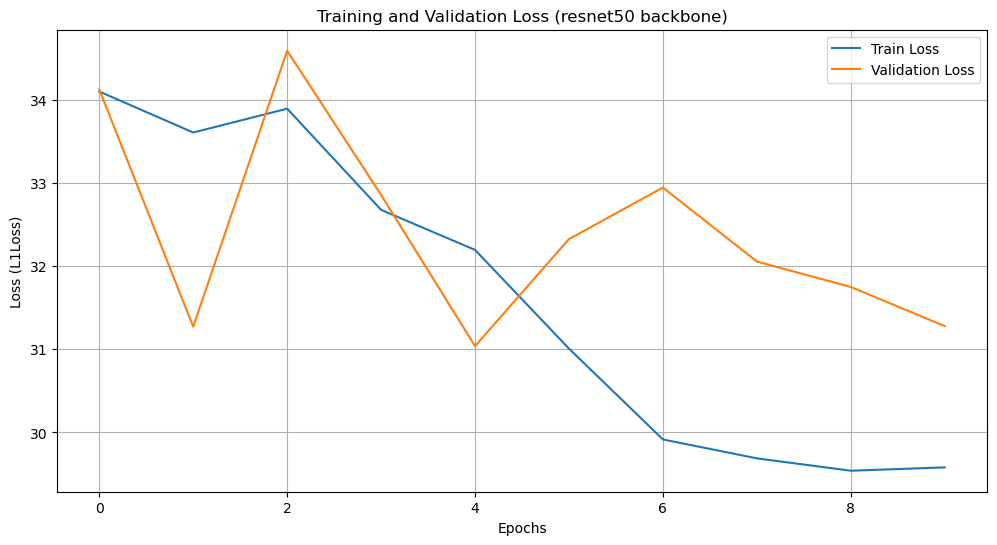


--- Evaluating best saved model (best_nutrition_regressor_resnet50.pth) on validation set ---

--- Evaluation Metrics ---
Overall Average Loss (L1Loss): 31.0384
  calories: MAE = 68.0407, PMAE = 28.15%, R2 = 0.7436
  weight: MAE = 64.2749, PMAE = 30.06%, R2 = 0.7121
  fat: MAE = 5.9496, PMAE = 49.64%, R2 = 0.5006
  carbs: MAE = 9.4663, PMAE = 51.21%, R2 = 0.3946
  protein: MAE = 7.4603, PMAE = 43.40%, R2 = 0.6230

Validation Metrics for Best Model:
  overall_avg_loss: 31.0384
  calories_MAE: 68.04073333740234
  calories_PMAE: 28.1514
  calories_R2: 0.7436
  weight_MAE: 64.2749252319336
  weight_PMAE: 30.0606
  weight_R2: 0.7121
  fat_MAE: 5.949587345123291
  fat_PMAE: 49.6367
  fat_R2: 0.5006
  carbs_MAE: 9.466277122497559
  carbs_PMAE: 51.2108
  carbs_R2: 0.3946
  protein_MAE: 7.460311412811279
  protein_PMAE: 43.4024
  protein_R2: 0.6230

MAE Values for Best Model:
  calories MAE: 68.0407
  weight MAE: 64.2749
  fat MAE: 5.9496
  carbs MAE: 9.4663
  protein MAE: 7.4603


In [29]:
# Cell 9: Main Training Execution & Plotting

# --- Configuration for this run (can be adjusted from Cell 1 or here) ---
# NUM_EPOCHS = 5 # Or get from Cell 1's definition
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # From Cell 1
# model, criterion, optimizer, scheduler are already defined from previous cells
# train_loader, val_loader are also defined

MODEL_SAVE_FILENAME = f"best_nutrition_regressor_{selected_backbone}.pth" # Use selected_backbone from Cell 5

if train_loader: # Only proceed if train_loader was successfully created
    print(f"\n--- Starting Training for {NUM_EPOCHS} epochs using {selected_backbone} backbone ---")
    print(f"Model will be saved to: {MODEL_SAVE_FILENAME}")

    # Ensure model is on the correct device before training
    model.to(DEVICE)
    
    training_history = train_model(
        model,
        train_loader,
        val_loader, # Pass val_loader for validation during training
        criterion,
        optimizer,
        scheduler=scheduler, # Pass the scheduler
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        model_save_path=MODEL_SAVE_FILENAME
    )
    
    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(training_history['train_loss'], label='Train Loss')
    if 'val_loss' in training_history and training_history['val_loss']: # Check if val_loss exists and is not empty
        plt.plot(training_history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel(f'Loss ({criterion.__class__.__name__})')
    plt.title(f'Training and Validation Loss ({selected_backbone} backbone)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Optional: Evaluate the best saved model on the validation set ---
    if val_loader and os.path.exists(MODEL_SAVE_FILENAME):
        print(f"\n--- Evaluating best saved model ({MODEL_SAVE_FILENAME}) on validation set ---")
        # Create a new instance of the model or use the current one
        # For safety, load into a fresh instance
        best_model = NutritionRegressor(num_outputs=num_target_outputs, backbone_name=selected_backbone, use_se=True) # Match your model config
        best_model.load_state_dict(torch.load(MODEL_SAVE_FILENAME))
        best_model.to(DEVICE)
        
        validation_metrics = evaluate_model(best_model, val_loader, criterion, DEVICE, target_names=TARGET_COLUMNS)
        print("\nValidation Metrics for Best Model:")
        for key, value in validation_metrics.items():
            print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

        print("\nMAE Values for Best Model:")
        for target in TARGET_COLUMNS:
            mae_key = f"{target}_MAE"
            if mae_key in validation_metrics:
                print(f"  {target} MAE: {validation_metrics[mae_key]:.4f}")
    elif not val_loader:
        print("No validation loader available to evaluate the best model.")
    elif not os.path.exists(MODEL_SAVE_FILENAME):
        print(f"Best model file {MODEL_SAVE_FILENAME} not found for evaluation.")

else:
    print("Skipping training as train_loader is not available. Check previous cells for errors in data loading or splitting.")

In [ ]:
# Cell 5: Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=DEVICE):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation
        if val_loader:
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * inputs.size(0)
            
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            history['val_loss'].append(epoch_val_loss)
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                # torch.save(model.state_dict(), 'best_nutrition_regressor.pth')
                # print("Best model saved.")
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}")
        
        # if scheduler: scheduler.step()
    
    print("Training Complete.")
    return history

# --- Start Training (if data is ready) ---
if train_loader:
    print("\n--- Starting Training ---")
    training_history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, DEVICE)
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(training_history['train_loss'], label='Train Loss')
    if val_loader and training_history['val_loss']:
        plt.plot(training_history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
else:
    print("Skipping training as train_loader is not available.")

In [ ]:
%store train_loader

# idea is this:
get segmentated pictures (something to work on)
    |- >
        back_bone
            | ->
            Feature Enhancement
                | ->
                3x FC


In [ ]:
class SimpleCNNRegressor(nn.Module):
    def __init__(self, num_nutrient_outputs=5): # num_nutrient_outputs should match len(TARGET_COLUMNS)
        super(SimpleCNNRegressor, self).__init__()
        # Convolutional layers
        # Input: [B, 3, 224, 224] (assuming 224x224 input from transforms)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        # Output: [B, 16, 224, 224] -> After ReLU -> Pool: [B, 16, 112, 112]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Output: [B, 32, 112, 112] -> After ReLU -> Pool: [B, 32, 56, 56]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Output: [B, 64, 56, 56] -> After ReLU -> Pool: [B, 64, 28, 28]
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # Output: [B, 128, 28, 28] -> After ReLU -> Pool: [B, 128, 14, 14]
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size after convolutions and pooling
        # For 224x224 input, after 4 pooling layers (each /2), size becomes 224 / (2^4) = 224 / 16 = 14
        # So, flattened_size = num_out_channels_last_conv * height * width
        self.flattened_size = 128 * 14 * 14 
        
        # Fully connected layers (Regression Head)
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.dropout1 = nn.Dropout(0.5) # Optional dropout
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.5) # Optional dropout
        self.fc3 = nn.Linear(128, num_nutrient_outputs) # Output layer

    def forward(self, x):
        # Convolutional blocks
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        # Flatten the output from conv layers
        x = x.view(-1, self.flattened_size) # Reshape to [BatchSize, flattened_size]
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x) # No activation for regression output
        
        return x

# Instantiate the simple CNN model
simple_model = SimpleCNNRegressor(num_nutrient_outputs=len(TARGET_COLUMNS)).to(DEVICE)
print("SimpleCNNRegressor Instantiated.")

# Test with a dummy input to verify shapes
dummy_input = torch.randn(BATCH_SIZE, 3, 224, 224).to(DEVICE) # BATCH_SIZE from your config
try:
    simple_output = simple_model(dummy_input)
    print(f"Dummy input test for SimpleCNNRegressor successful. Output shape: {simple_output.shape}") # Should be [BATCH_SIZE, num_outputs]
except Exception as e:
    print(f"Error during dummy input test for SimpleCNNRegressor: {e}")


In [ ]:
# Cell: Define Loss, Optimizer, and Train the Simple CNN

# (Ensure train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE are defined from previous cells)
# Example: NUM_EPOCHS = 20 # May need more for a simple CNN to learn something
# Example: LEARNING_RATE = 0.001

# Loss function (MSE is common for regression)
simple_criterion = nn.MSELoss()
# simple_criterion = nn.L1Loss() # MAE Loss

# Optimizer
simple_optimizer = optim.Adam(simple_model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (optional, but can be helpful)
# simple_scheduler = optim.lr_scheduler.StepLR(simple_optimizer, step_size=10, gamma=0.1)

# Re-use the training loop function defined earlier (if it's generic enough)
# Or define it here again if you made it specific to the ResNet model.
# Assuming 'train_model' function is available from previous cells for the ResNet training.
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=DEVICE, scheduler=None): ...

# --- Start Training the Simple CNN (if data is ready) ---
if train_loader: # Check if train_loader was successfully created
    print("\n--- Starting Training for SimpleCNNRegressor ---")
    
    # If your train_model function takes a scheduler, pass simple_scheduler
    simple_training_history = train_model(
        simple_model,
        train_loader,
        val_loader, # Can be None if no validation set
        simple_criterion,
        simple_optimizer,
        num_epochs=NUM_EPOCHS, # Use a suitable number of epochs
        device=DEVICE
        # scheduler=simple_scheduler # Uncomment if using a scheduler
    )
    
    # Plot training history
    if simple_training_history:
        plt.figure(figsize=(10, 5))
        plt.plot(simple_training_history['train_loss'], label='SimpleCNN Train Loss')
        if val_loader and simple_training_history.get('val_loss'): # Check if 'val_loss' key exists
            plt.plot(simple_training_history['val_loss'], label='SimpleCNN Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSE or MAE)')
        plt.title('SimpleCNNRegressor Training and Validation Loss')
        plt.legend()
        plt.show()
        
    # Save the trained simple model (optional)
    # torch.save(simple_model.state_dict(), 'simple_cnn_nutrition_regressor.pth')
    # print("Trained SimpleCNNRegressor model state saved.")

else:
    print("Skipping SimpleCNNRegressor training as train_loader is not available.")